In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# Plotting settings
a_min = 1e-3
a_max = 1
margin = 1.3

# Linear predictions

In [2]:
# from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [3]:
import numpy as np
from sympy import symbols, sqrt, lambdify, Function, solve, Derivative, init_printing, exp
init_printing()
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

In [4]:
plt.style.use('./my_style.py')
import matplotlib.ticker as mticker

from cycler import cycler
import matplotlib.cm     as cm

In [5]:
#Symbolic variables
x, y, mu, k, E_diffa= symbols(r' x, y, \mu, k, E_a')
a= symbols('a', positive=True)
D= Function('D')
E = Function('E')(a)

In [6]:
# h =  0.6774
Om0 = 0.3089
# Om0 = 0.3

Ol0 = 1- Om0
H0_hinvMpc= 1/2997.92458

In [7]:
z_ini = 33333
z_fin = 0

a_ini = 1/(1+z_ini)
a_fin = 1/(1+z_fin)

z_eval = np.array([ 1.65,1.4,1.2,1])
a_eval = 1/(1+z_eval)

In [8]:
H = H0_hinvMpc*E
H_LCDM = H0_hinvMpc*sqrt(Om0*a**(-3) + Ol0)
H_LCDM_Or = H0_hinvMpc*sqrt(Om0*a**(-3) + Ol0+ 8*10**(-5)*a**(-4))
H_conf = H*a
Om = Om0*a**(-3)
Ol = Ol0

# Ben's data

### Background

In [9]:
header_str = 'a,  H_MG,  H_LCDM, H_MG/H_LCDM,  aH dH/da / H0^2 ,  phi , d phi/ dlna'
header = [s.strip(' ')for s in header_str.split(',')]

In [10]:
df_Ben_BG = pd.DataFrame(np.loadtxt('./Data/Background/background_k01_glam.dat'), columns=header).set_index('a')

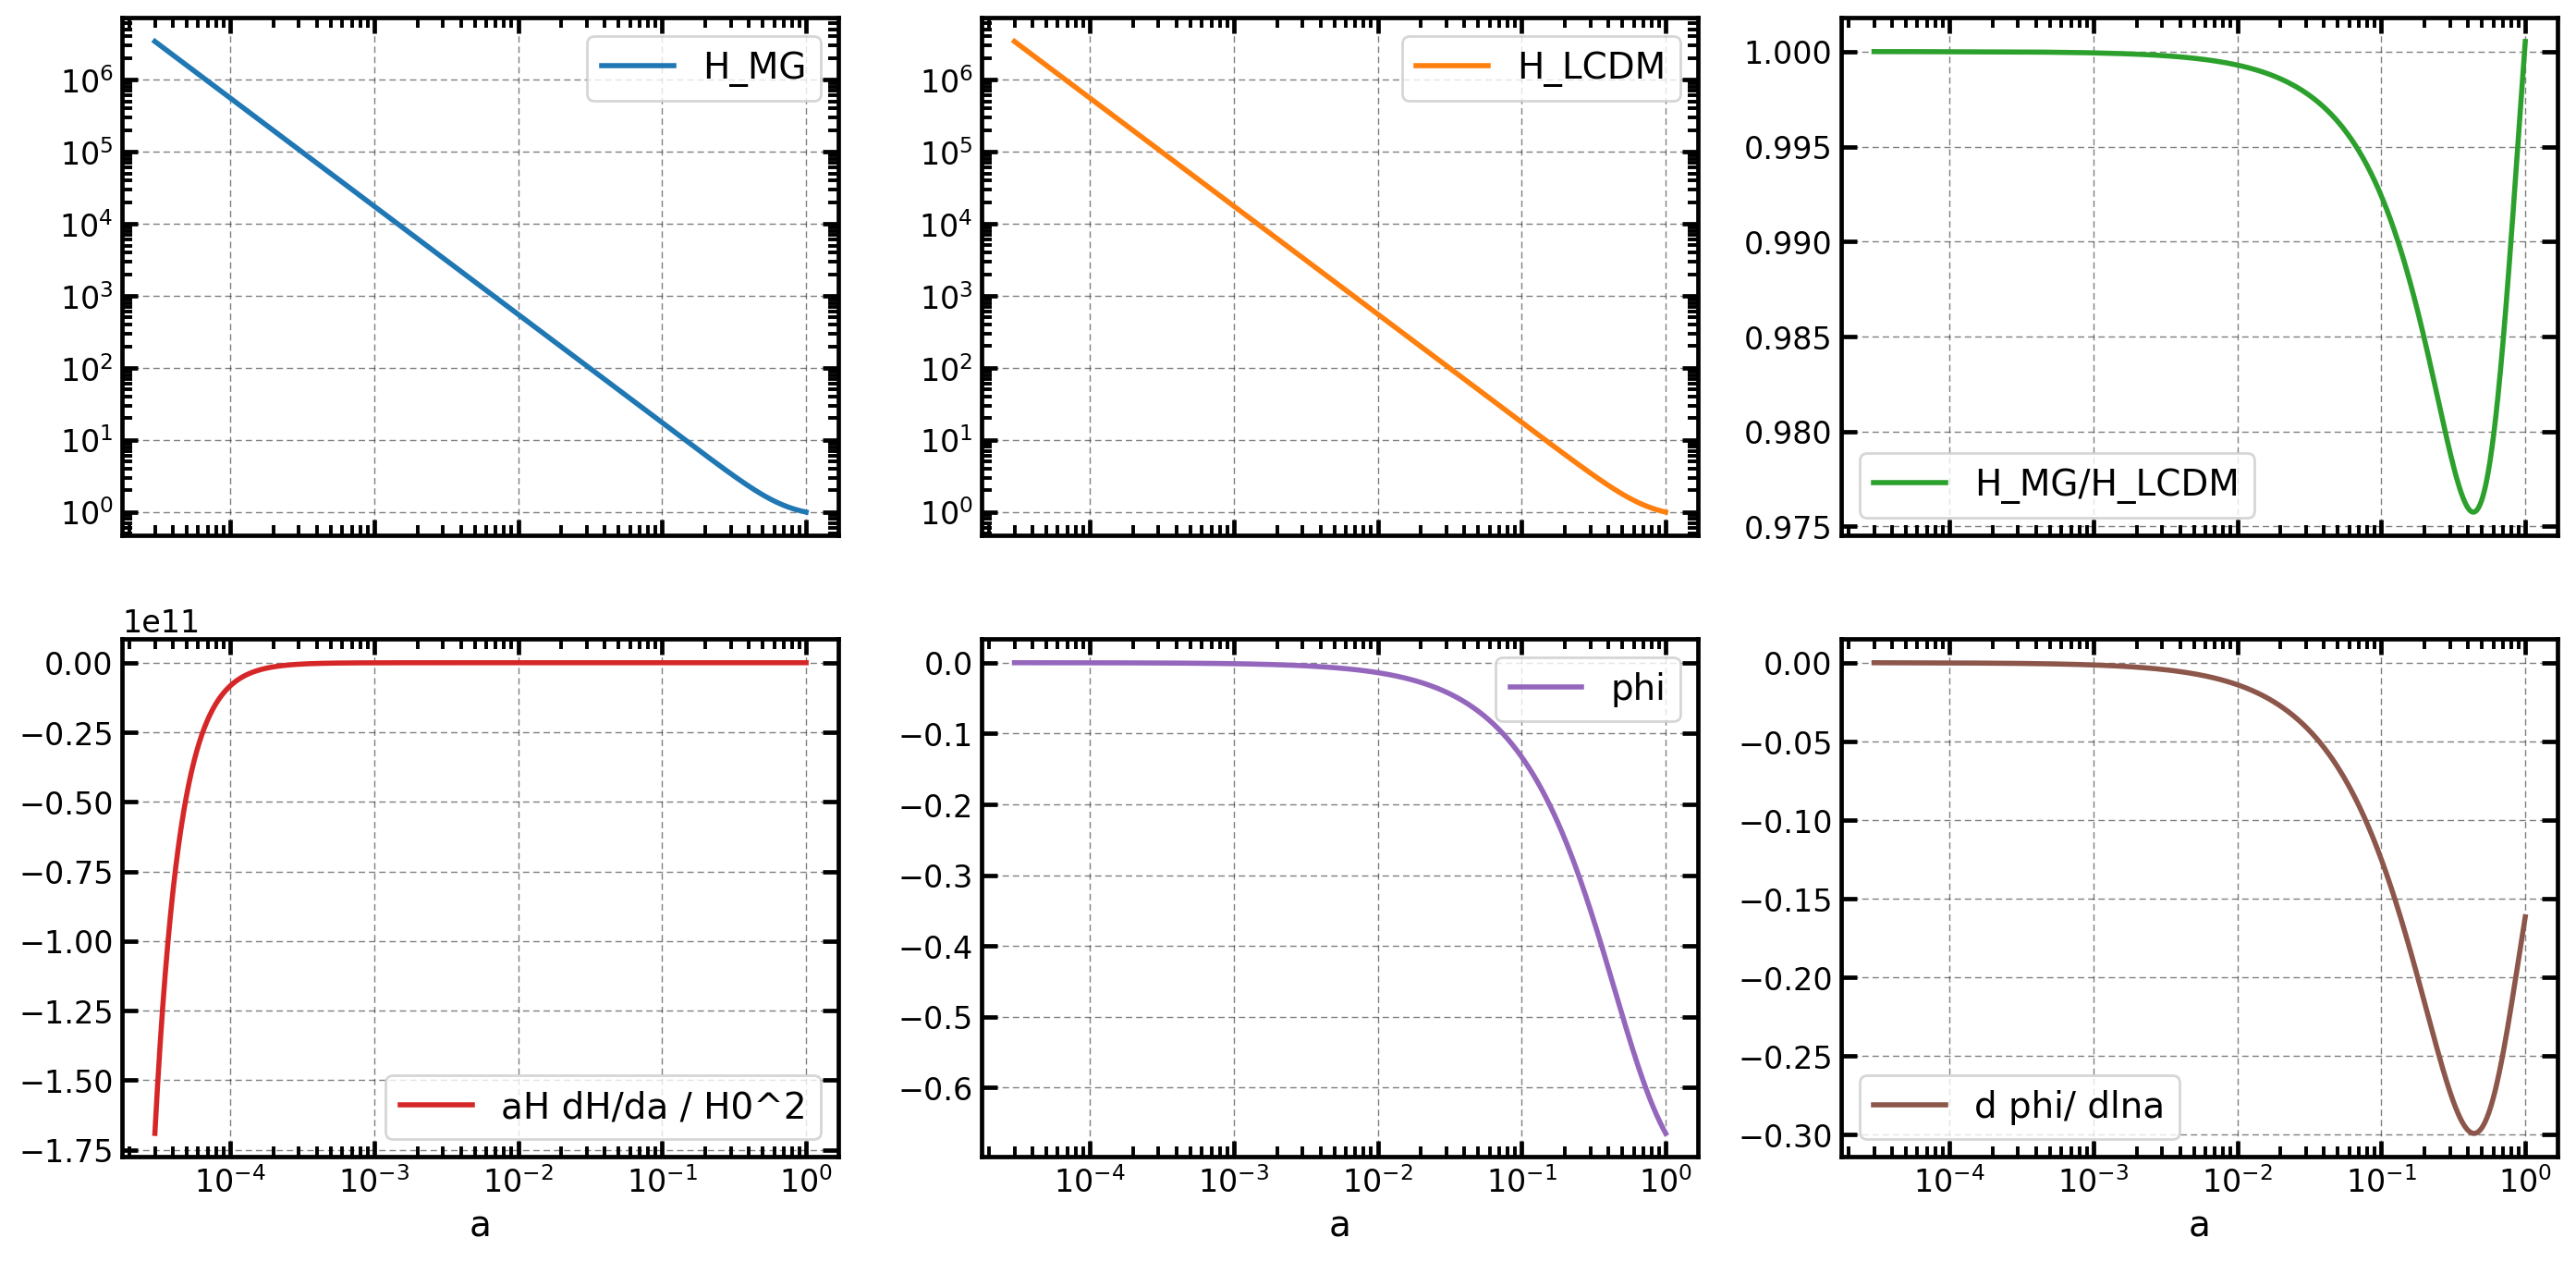

In [11]:
fig, axs = plt.subplots(2,3, figsize=(17,8), sharex=True)
df_Ben_BG.plot(ax=axs, subplots=True)

for ax in axs.flatten():
    ax.set_xscale('log')
    if (ax.get_ylim()[1]>10) and (ax.get_ylim()[0]>-1e9):
        ax.set_yscale('log')

In [12]:
a_vals = df_Ben_BG.index

phi_kmou = InterpolatedUnivariateSpline(a_vals, df_Ben_BG['phi'])
phi_diffa_kmou = phi_kmou.derivative()
E_kmou = InterpolatedUnivariateSpline(a_vals, df_Ben_BG['H_MG'])
E_diffa_kmou = E_kmou.derivative()
phi_prime_kmou = lambda a: a*(a*E_kmou(a)*H0_hinvMpc)*phi_diffa_kmou(a)

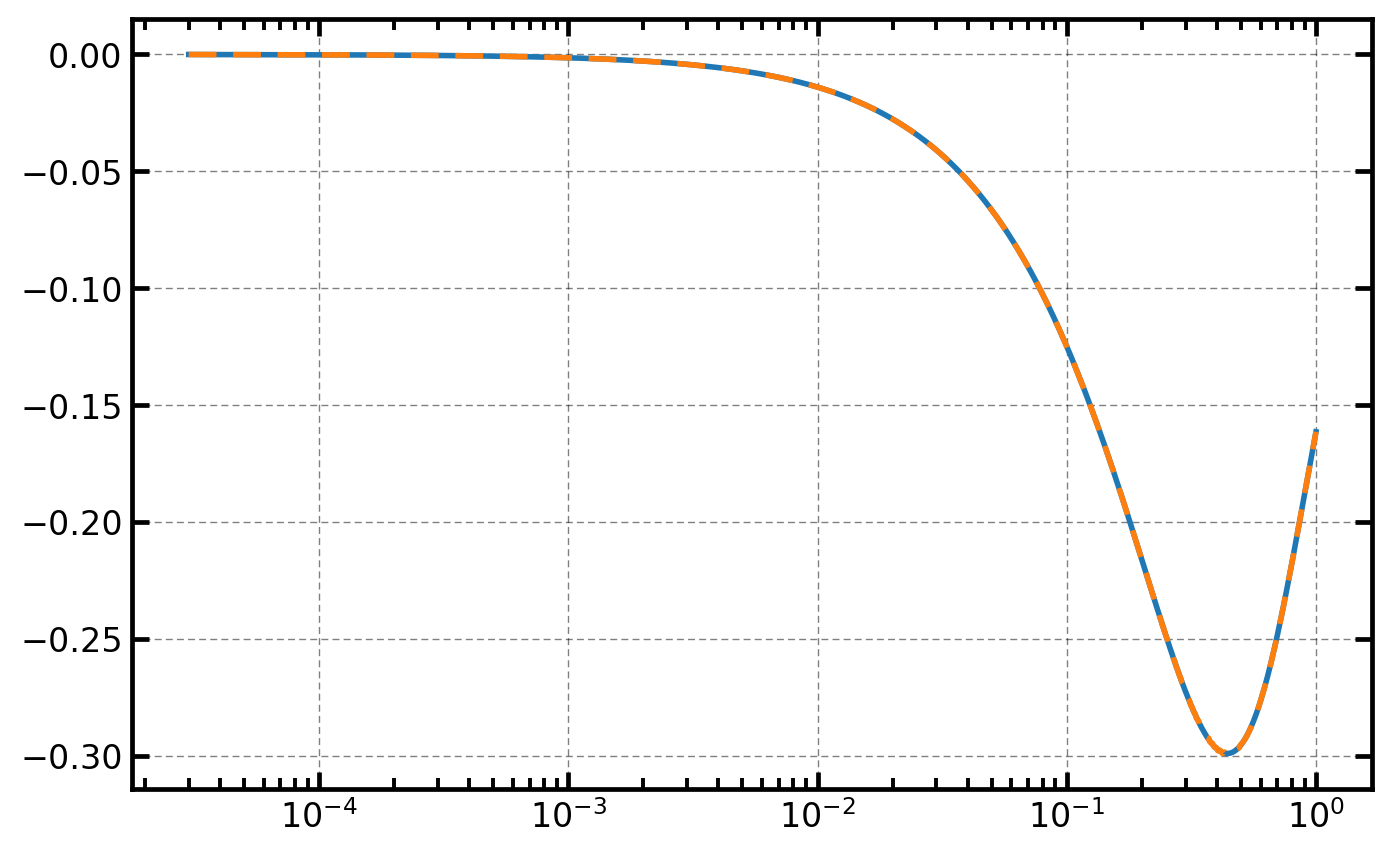

In [13]:
plt.semilogx(df_Ben_BG['d phi/ dlna'])
plt.semilogx(a_vals, a_vals*phi_diffa_kmou(a_vals), '--')

# Expansion

In [14]:
E_vals_LCDM = lambdify((a),H_LCDM/H0_hinvMpc)(df_Ben_BG.index)

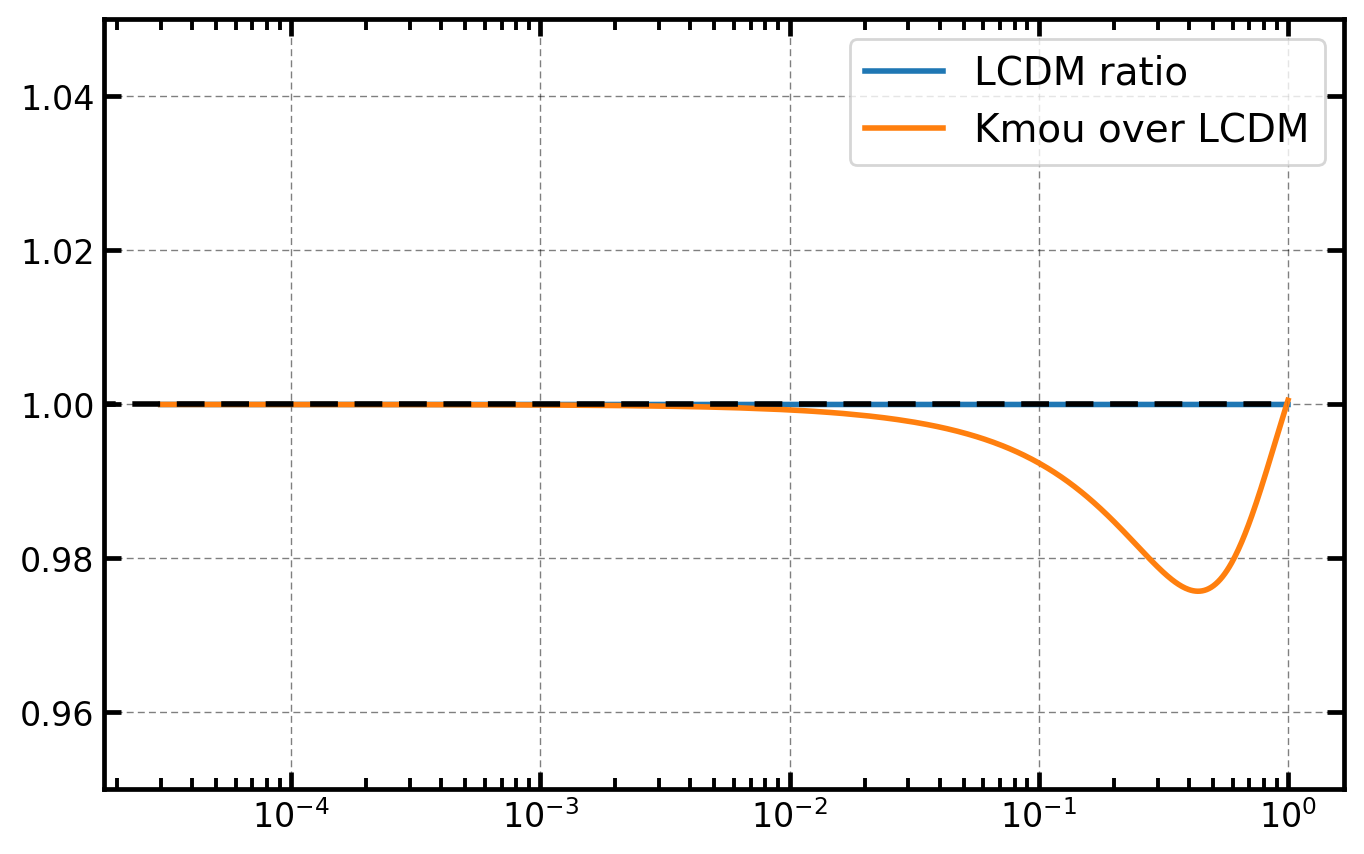

In [15]:
plt.semilogx(df_Ben_BG['H_LCDM']/E_vals_LCDM, label='LCDM ratio')
plt.semilogx(df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou over LCDM')
plt.ylim(0.95,1.05)
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.legend();

# Growth equation

#### $\Lambda$CDM

The growth equation in LCDM reads:
$$D_{1}'' + \mathcal{H} D_{1}' - \frac{3}{2} \, \Omega_{m} H_{0}^{2} a^{2} D_{1} = 0.$$
It is possible to express the derivatives wrt the conformal time in terms of the scale factor:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

In [16]:
# Set up differential equation
diff_eq_LCDM = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf**2*D(a).diff(a) \
                -3/2*Om*H0_hinvMpc**2*a**(2)*D(a)

diff_eq_LCDM = diff_eq_LCDM.expand().subs(E, H_LCDM/H0_hinvMpc)

And then solve the differntial equation numerically:

In [17]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_LCDM.subs(D(a).diff(a),x).subs(D(a),y)
x_eq= lambdify((a,x,y), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1]),y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_LCDM = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

#### $k$-mouflage

The growth equation for the k-mouflage model in the Einstein frame reads:
$$D_{1}^{\prime \prime}+\left[\frac{a^{\prime}}{a}+\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi} \varphi^{\prime}\right] D_{1}^{\prime}-4 \pi G \bar{\rho}_{\mathrm{m}}(a) a^2 A(\bar{\varphi})\left[1+\frac{2 \beta_{\mathrm{Kmo}}^2}{K_X(\bar{X})}\right] D_{1}=0$$
where the conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$
Here we focus on the model:
$$K(X)=-1+X+K_0 X^n$$
with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{\bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [18]:
# Define kmouflage quantities
beta = 0.2
phi, phi_prime, X = symbols(r'\phi, \phi^{\prime}, X')
A = exp(beta*phi)

n=2
K0=1
lamb= 1.476
K = -1 + X + K0*X**n
K_x = K.diff(X)
X_bar = phi_prime**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)

mu_kmou = 1+ 2*beta**2/(K_x_bar)

In [19]:
# Set up differential equation
diff_eq_kmou = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf+beta*phi_prime)*D(a).diff(a) \
                -3/2*Om*H0_hinvMpc**2*a**(2)*A*mu_kmou*D(a)

diff_eq_kmou = diff_eq_kmou.expand()

And then solve the differntial equation numerically:

In [20]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_kmou.subs(D(a).diff(a),x).subs(D(a),y).subs(E.diff(a),E_diffa)

x_eq= lambdify((a,x,y,E,E_diffa,phi,phi_prime), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

In [21]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1], E_kmou(t),E_diffa_kmou(t), phi_kmou(t), phi_prime_kmou(t)),
            y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_kmou = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

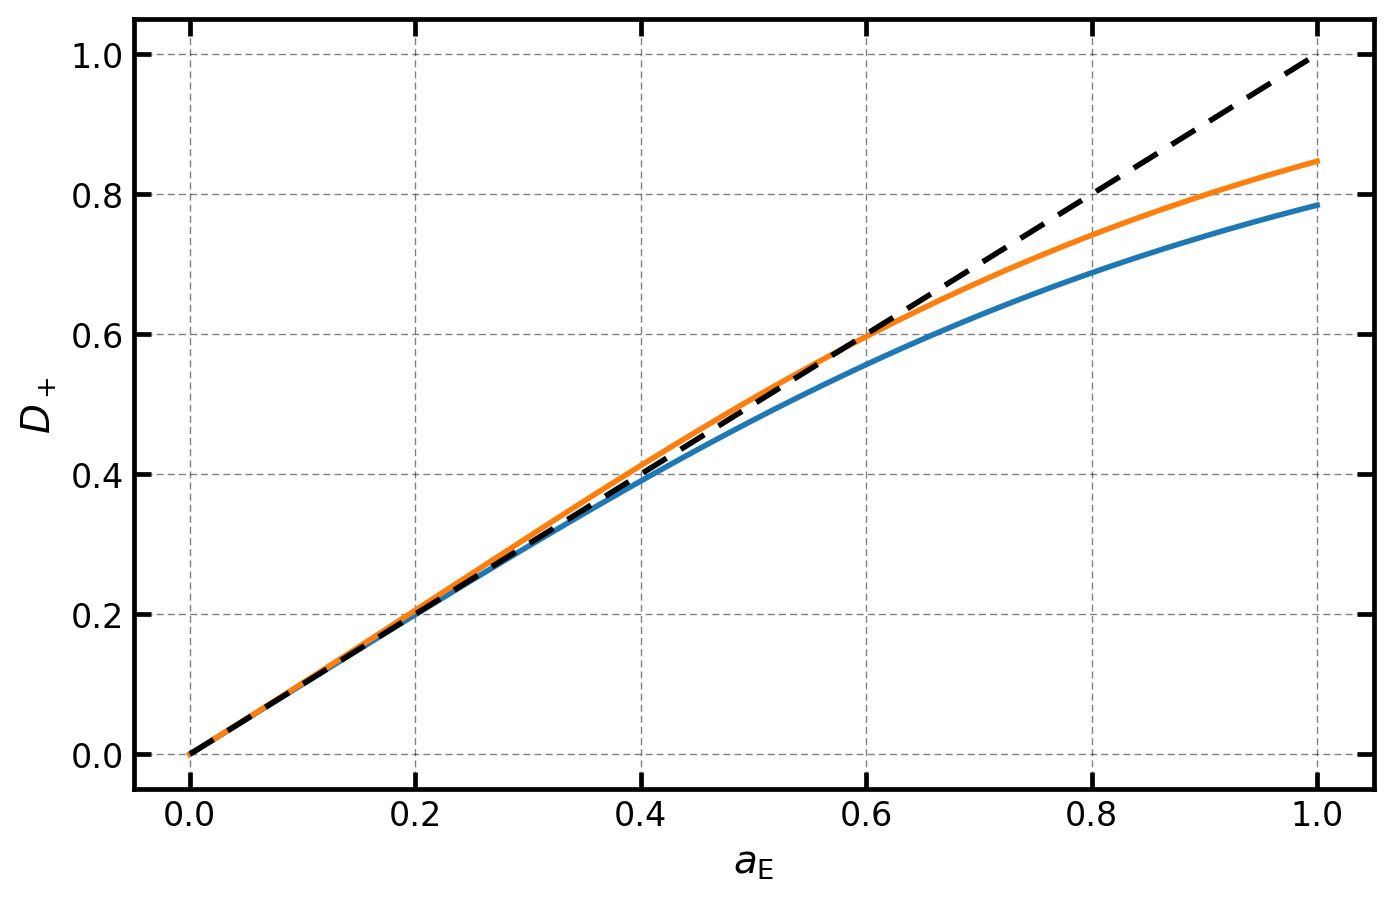

In [22]:
plt.plot(df_Ben_BG.index, D_LCDM.sol(df_Ben_BG.index)[1])
plt.plot(df_Ben_BG.index, D_kmou.sol(df_Ben_BG.index)[1])
plt.plot(df_Ben_BG.index, df_Ben_BG.index, 'k--')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$D_+$');

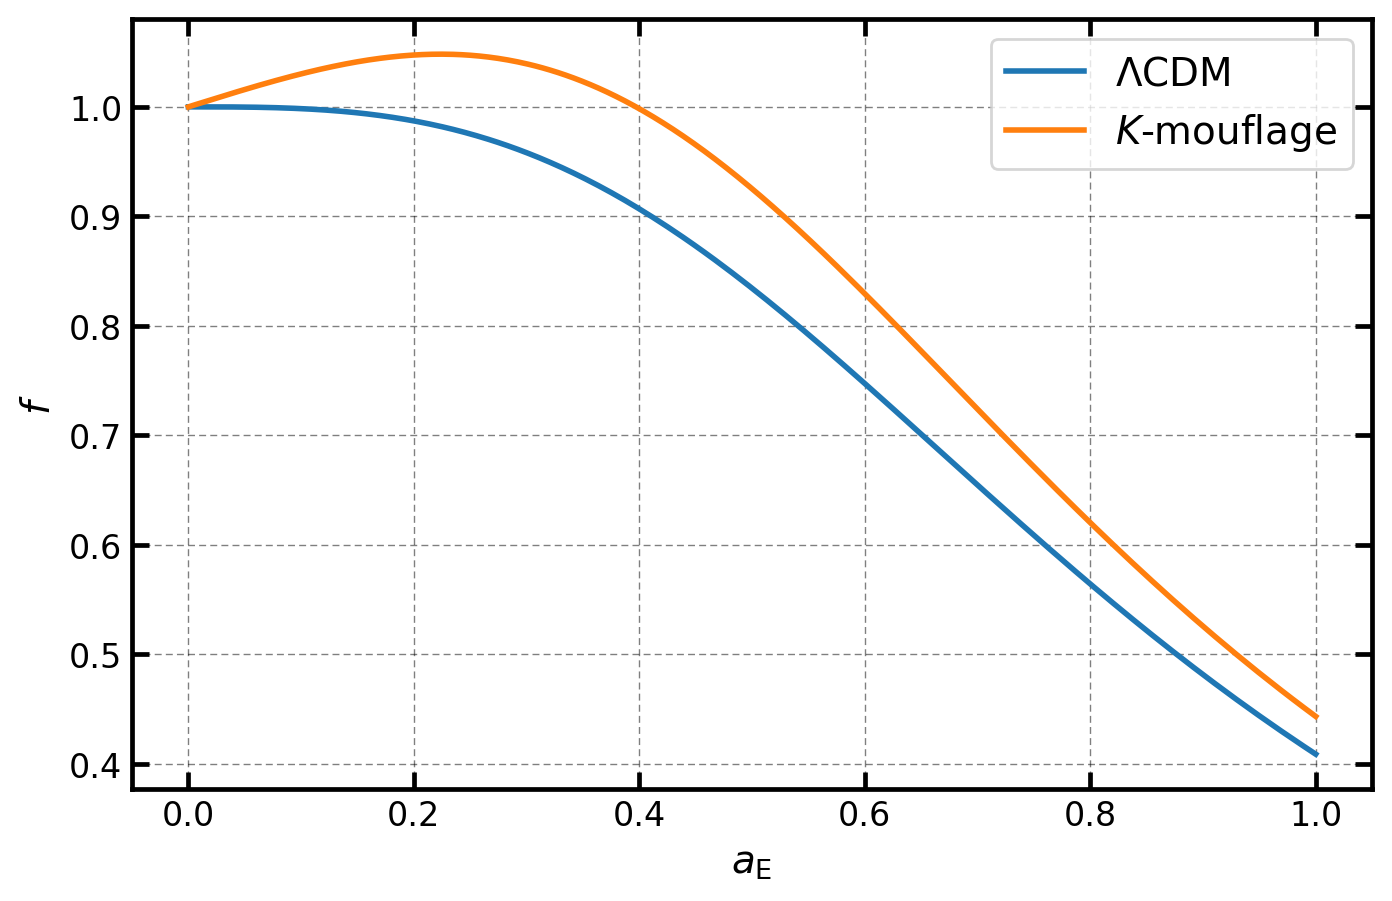

In [23]:
plt.plot(df_Ben_BG.index, D_LCDM.sol(df_Ben_BG.index)[0], label=r'$\Lambda$CDM')
plt.plot(df_Ben_BG.index, D_kmou.sol(df_Ben_BG.index)[0], label=r'$K$-mouflage')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$f$');
plt.legend();

# Frame transformation

In the Einstein frame the scalar field is minimally coupled with the gravity and the units of lenght are controlled by the conformal factor $A(\phi)$ and so they can vary with time. 

In the Jordan frame the scalar field has non-minimal coupling with gravity but the units are time-independent.

(see Francfurt et al 1907.03606)

Convention:
- no tilde for Einstein frame
- tilde for Jordan frame

The Hubble paramteter tranforms between the two frames like:
$$\tilde{\mathcal{H}} = \mathcal{H}-\frac{\dot{\phi} F^{\prime}}{2 F}$$
where $\dot{\phi} = \frac{d\phi}{d\tau}$, $F^{\prime} = \frac{d F}{d\phi}$ and $F=1/A^2$.

For the Hubble rate this corresponds to:
$$\tilde{H} = \frac{H}{A} (1 + a \beta \frac{d \phi}{da} )$$

<!-- Also the k-mouflage function $k\equiv (K+1)/X$ transforms as:
$$ k=\frac{3}{16 \pi G}\left(\frac{F^{\prime}}{F}\right)^2+\frac{\tilde{k}}{F}. $$ -->

<!-- or reversing the frames:
$$\tilde{k}= F k -\frac{3 F}{16 \pi G}\left(\frac{F^{\prime}}{F}\right)^2 .$$ -->

# Jordan frame

#### Background

In [24]:
beta = 0.2

In [25]:
A_vals = np.e**(beta* df_Ben_BG['phi'])

In [26]:
a_E_vals = df_Ben_BG.index.values
a_J_vals = a_E_vals*A_vals

In [27]:
H_J = df_Ben_BG['H_MG']/A_vals * (1 + a_E_vals*beta*phi_diffa_kmou(a_E_vals))

In [28]:
E_vals_LCDM_J = lambdify((a),H_LCDM/H0_hinvMpc)(a_J_vals)

#### Interpolate

In [29]:
phi_kmou_J = InterpolatedUnivariateSpline(a_J_vals, df_Ben_BG['phi'], ext=3)
phi_diffa_kmou_J = phi_kmou_J.derivative()
E_kmou_J = InterpolatedUnivariateSpline(a_J_vals, H_J, ext=3)
E_diffa_kmou_J = E_kmou_J.derivative()
phi_prime_kmou_J = lambda a: a*(a*E_kmou_J(a)*H0_hinvMpc)*phi_diffa_kmou_J(a)

#### Hubble Ratio

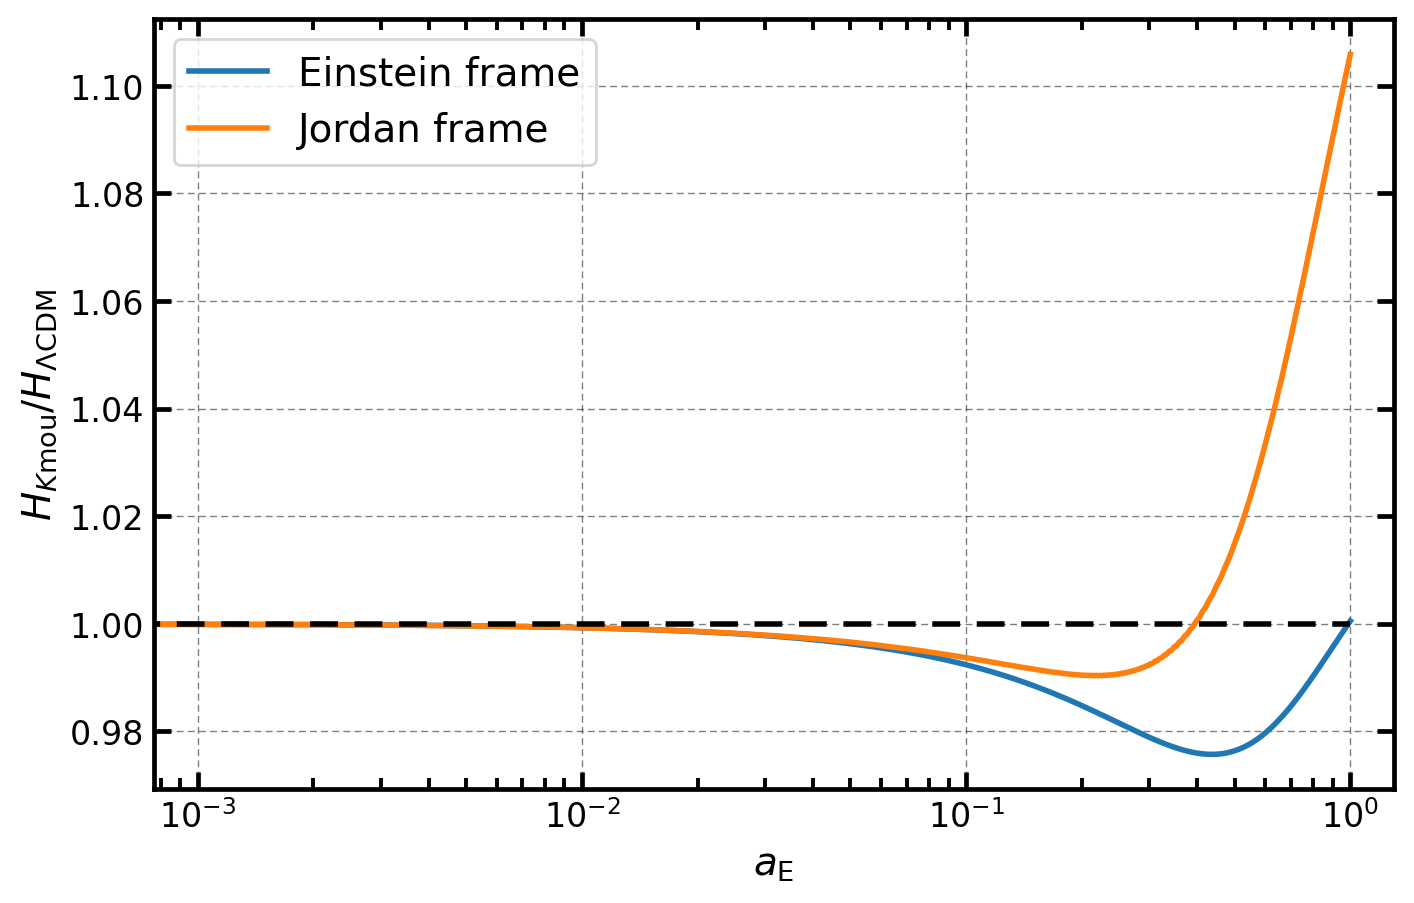

In [30]:
# plt.plot(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-E')
plt.plot(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Einstein frame')
plt.plot(a_E_vals, H_J/E_vals_LCDM, label='Jordan frame')
plt.xscale('log')
plt.xlim(a_min/margin, a_max*margin)
y_min, y_max = plt.ylim()
# plt.vlines(A_vals.iloc[-1], y_min, y_max, linestyles=':', colors='k')
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel(r'$H_{K{\rm mou}}/H_{\Lambda {\rm CDM}}$')
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/HubbleRateRatio.pdf', format='pdf')

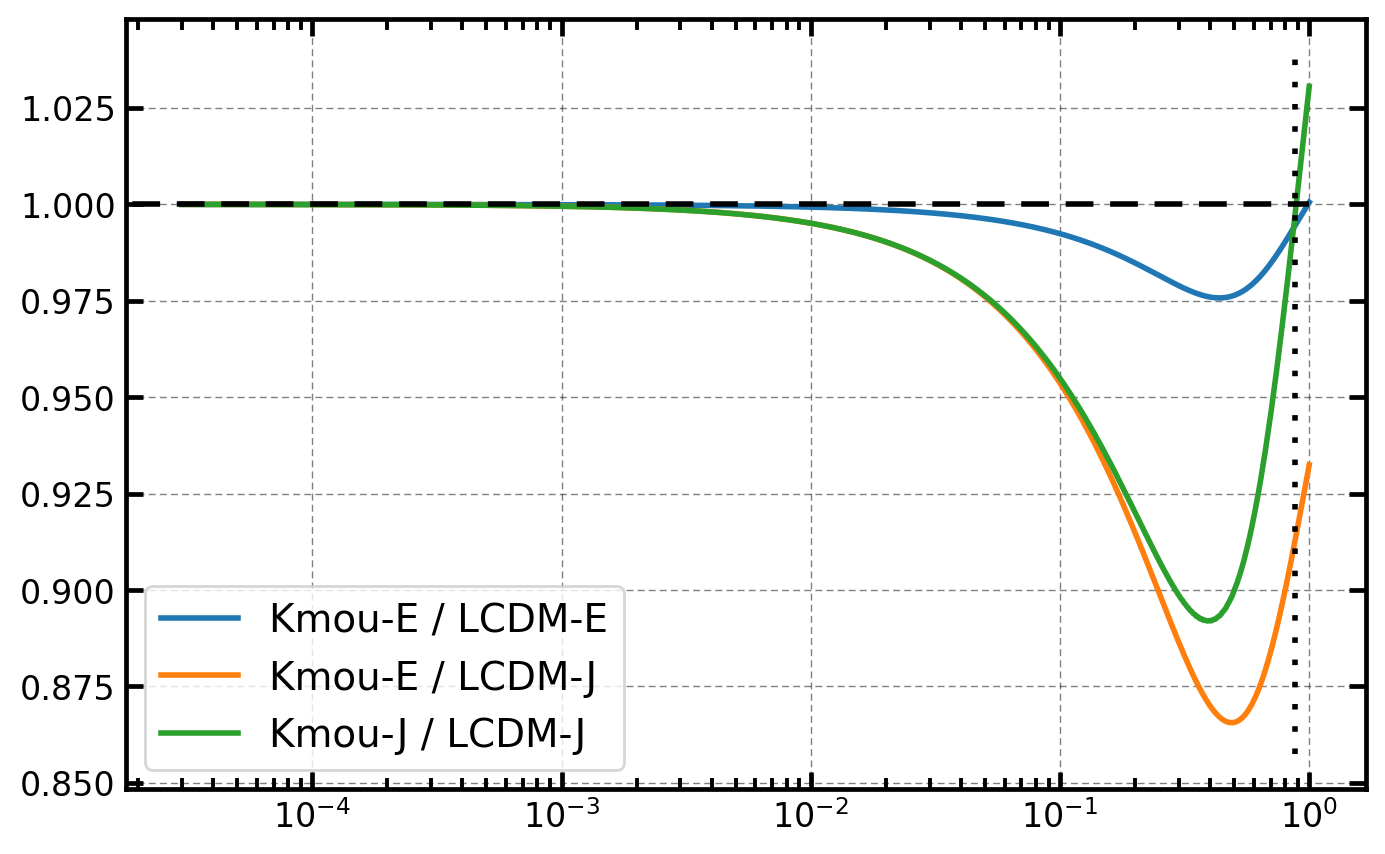

In [31]:
# plt.semilogx(a_E_vals, E_vals_LCDM_J/df_Ben_BG['H_LCDM'], label='LCDM ratio: J / E')
plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-E')
plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM_J, label='Kmou-E / LCDM-J')
# plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-J')
plt.semilogx(a_E_vals, H_J/E_vals_LCDM_J, label='Kmou-J / LCDM-J')
# plt.semilogx(a_E_vals, (1 + a_E_vals*beta*phi_diffa_kmou(a_E_vals)),'--', label=r'$\mathcal{H}_{kmou}^J/\mathcal{H}_{kmou}^E$')
# plt.semilogx(a_E_vals, H_j/E_vals_LCDM_J, label='Kmou-Jordan over LCDM')
y_min, y_max = plt.ylim()
plt.vlines(A_vals.iloc[-1], y_min, y_max, linestyles=':', colors='k')
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.legend();

#### $k$-mouflage

The growth equation for the k-mouflage model in the Jordan frame reads:
$$D_{1}'' + \mathcal{H} D_{1}' - \frac{3}{2} \, A^2 \Omega_{m} H_{0}^{2} a^{2} \mu D_{1} = 0,$$
where $\mu = 1+\epsilon_1$, $\epsilon_1 = \frac{2 \beta^2}{K_x}$ and $\Omega_{m}$ is the Einstein frame matter density, hence the presence of the $A^2$ factor to take into account the running of the Planck mass in the Jordan frame and how densities transform between the two frames.

The conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$

We use the Einstein frame model:
$$K(X)=-1+X+K_0 X^n$$
<!-- is translated in the Jordan frame as:
$$\tilde{K}= X \tilde{k} -1 = X -1 = -1+X+K_0 X^n$$ -->

with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{A^2 \bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [32]:
# Define kmouflage quantities
beta = 0.2
phi, phi_prime, X = symbols(r'\phi, \phi^{\prime}, X')
A = exp(beta*phi)

n=2
K0=1
lamb= 1.476
K = -1 + X + K0*X**n
K_x = K.diff(X)
X_bar_J = A**2*phi_prime**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
# X_bar = phi_prime**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar_J = K_x.subs(X, X_bar_J)
# K_x_bar = K_x.subs(X, X_bar)

mu_kmou_J = 1 + 2*beta**2/(K_x_bar_J)
# mu_kmou = 1 + 2*beta**2/(K_x_bar)

In [34]:
# Set up differential equation
# diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
#                 -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
                -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

# diff_eq_kmou_j = a*(a*D(a).diff(a)).diff(a) + (2+1/H**2*a*H*H.diff(a))*a*D(a).diff(a) \
#                 -3/2*Om*(H0_hinvMpc/H)**2*mu_kmou_J*D(a)

diff_eq_kmou_j = diff_eq_kmou_j.expand()

And then solve the differntial equation numerically:

In [35]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_kmou_j.subs(D(a).diff(a),x).subs(D(a),y).subs(E.diff(a),E_diffa)

x_eq= lambdify((a,x,y,E,E_diffa,phi,phi_prime), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

In [37]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1], E_kmou_J(t),E_diffa_kmou_J(t), phi_kmou_J(t), phi_prime_kmou_J(t)),
            y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_kmou_J = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

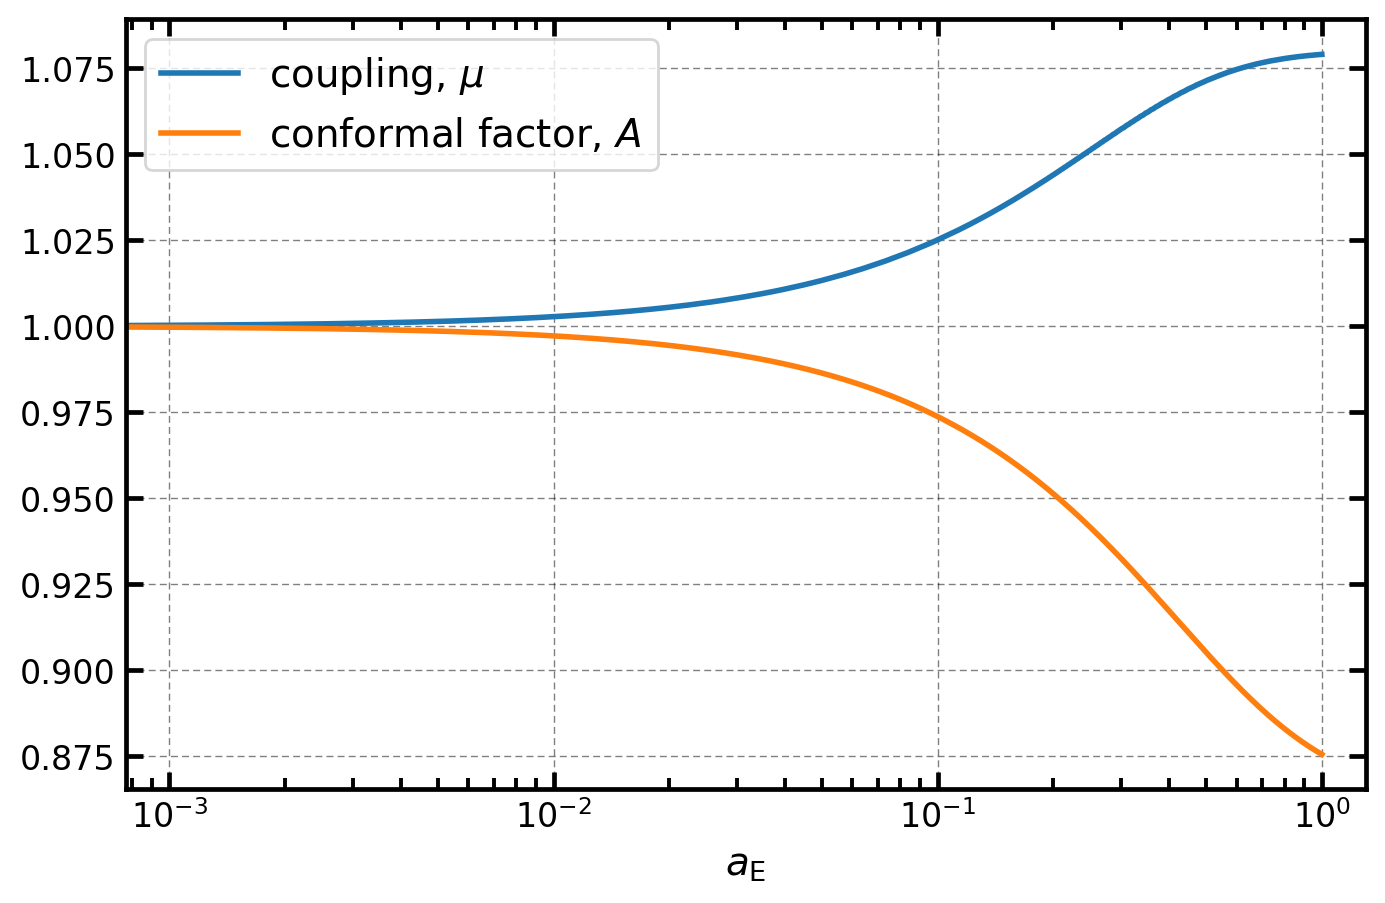

In [55]:
plt.semilogx(a_E_vals, lambdify([a, phi, phi_prime], mu_kmou_J)(a_J_vals,
                                                              phi_kmou_J(a_J_vals),
                                                              phi_prime_kmou_J(a_J_vals)), 
             label=r'coupling, $\mu$')

plt.semilogx(a_E_vals, lambdify([phi], A)(phi_kmou(a_E_vals)), label=r'conformal factor, $A$')

plt.xlabel(r'$a_{\rm E}$')

plt.legend()
plt.xlim(a_min/margin, a_max*margin)
plt.savefig('./figures/n2-beta0p2-k1/MG-effects.pdf', format='pdf')

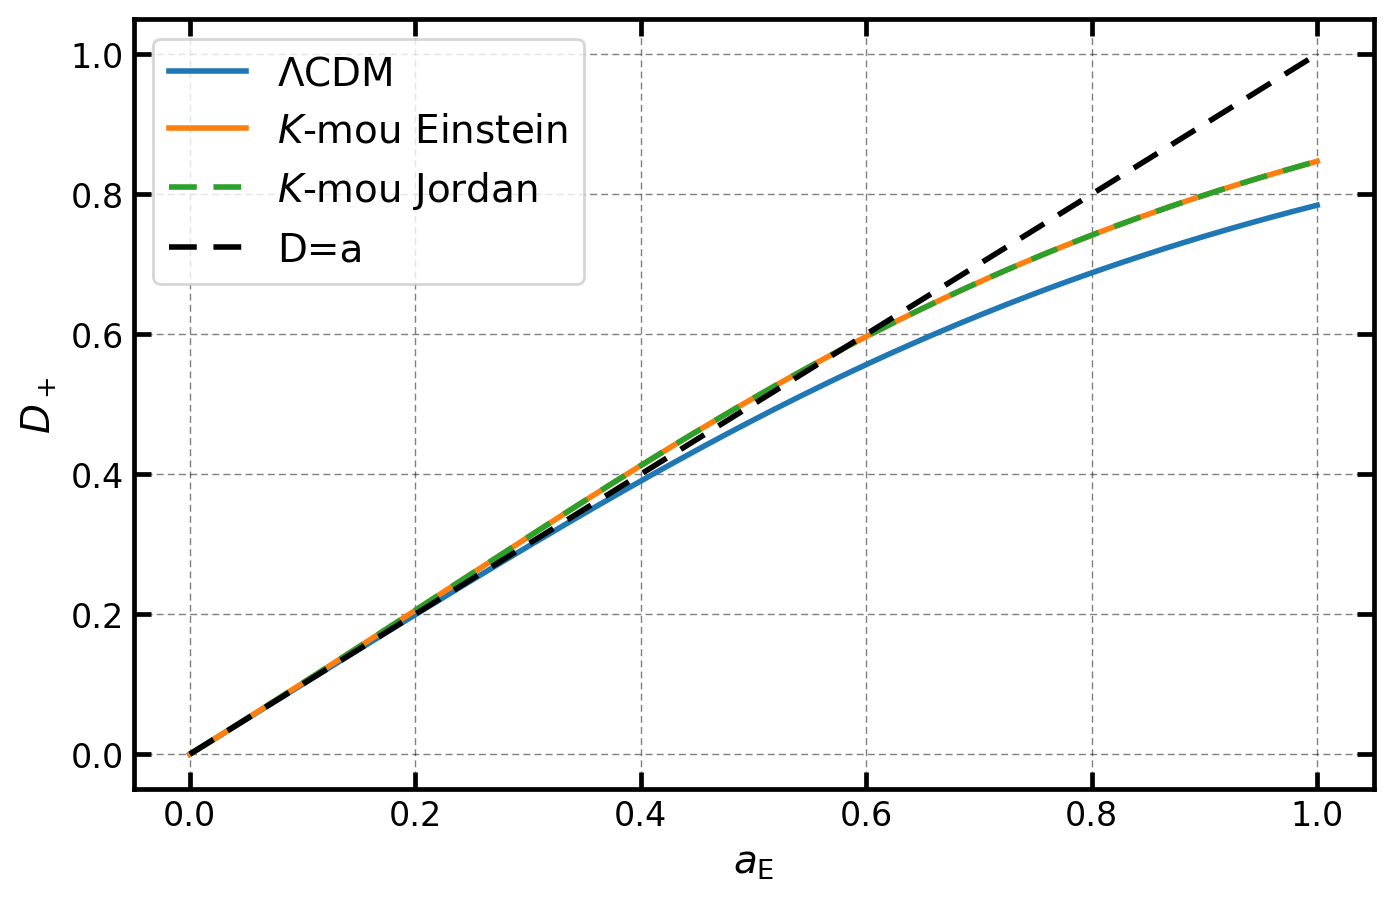

In [39]:
plt.plot(a_E_vals, D_LCDM.sol(a_E_vals)[1], label=r'$\Lambda$CDM')
plt.plot(a_E_vals, D_kmou.sol(df_Ben_BG.index)[1], label='$K$-mou Einstein')
plt.plot(a_E_vals, D_kmou_J.sol(a_J_vals)[1], '--',label='$K$-mou Jordan')
plt.plot(a_E_vals , a_E_vals, 'k--', label='D=a')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$D_+$');
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/Growth_comp.pdf', format='pdf')

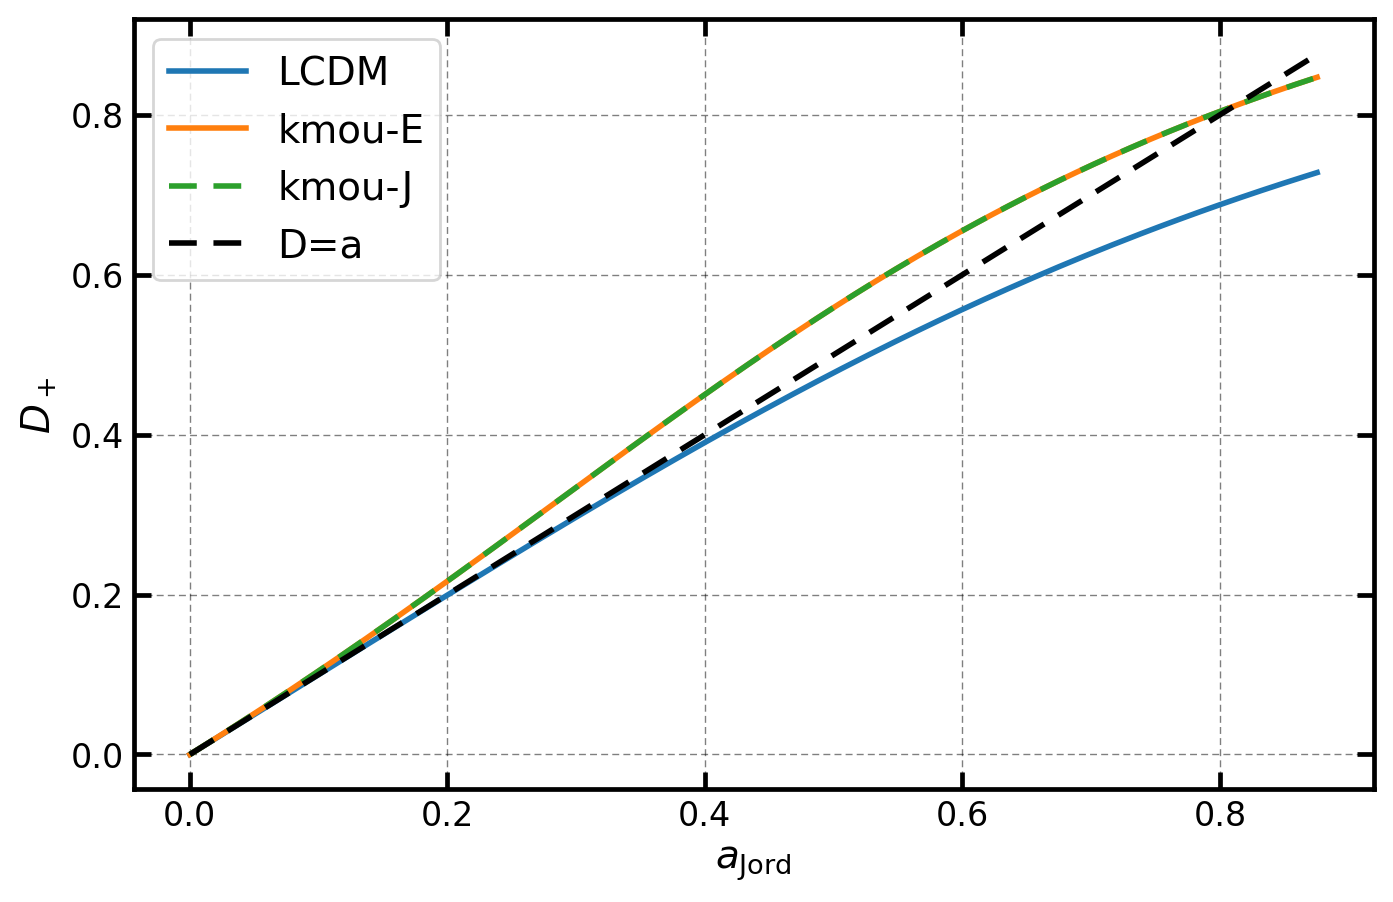

In [40]:
plt.plot(a_J_vals, D_LCDM.sol(a_J_vals)[1], label='LCDM')
plt.plot(a_J_vals, D_kmou.sol(df_Ben_BG.index)[1], label='kmou-E')
plt.plot(a_J_vals, D_kmou_J.sol(a_J_vals)[1], '--',label='kmou-J')
plt.plot(a_J_vals , a_J_vals, 'k--', label='D=a')
plt.xlabel(r'$a_{\rm Jord}$')
plt.ylabel('$D_+$');
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/Growth_comp_Jordan.pdf', format='pdf')

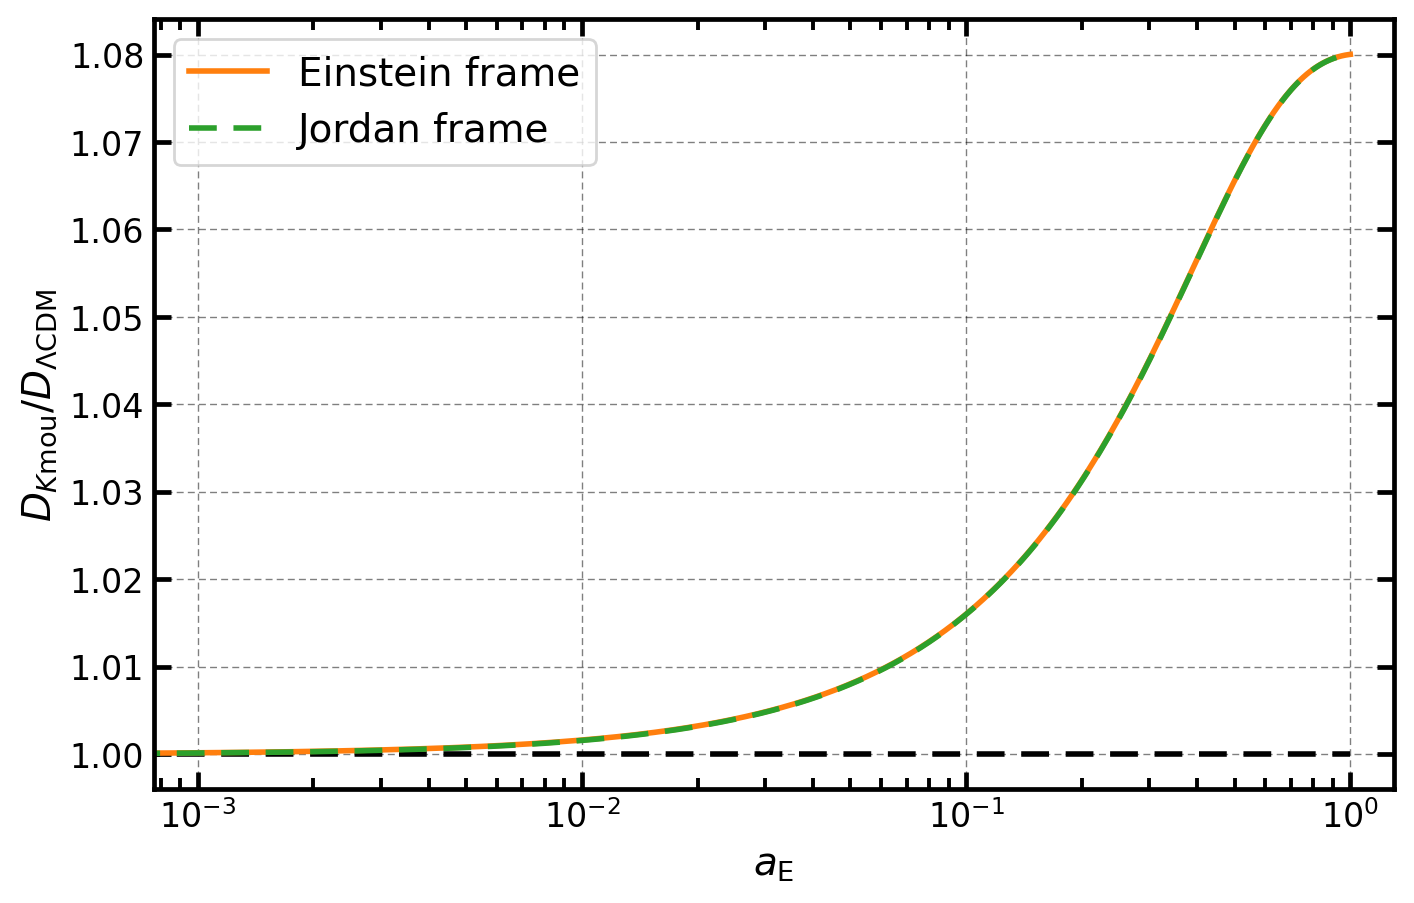

In [45]:
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.semilogx(a_E_vals, D_kmou.sol(df_Ben_BG.index)[1]/D_LCDM.sol(a_E_vals)[1], 'C1',label=r'Einstein frame')
plt.semilogx(a_E_vals, D_kmou_J.sol(a_J_vals)[1]/D_LCDM.sol(a_E_vals)[1], '--C2',label=r'Jordan frame' )
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel(r'$D_{K \rm mou}/D_{\rm \Lambda CDM}$');
plt.legend();
plt.xlim(a_min/margin, a_max*margin)
plt.savefig('./figures/n2-beta0p2-k1/Growth_ratios.pdf', format='pdf')

### Estimate differences in the power spectrum between frames

In [52]:
# Check if power spectrum changes between frames depending on scale 
scale_of_interest = 1e-2 # in h/Mpc
delta_phi_over_delta = A*beta*a**2*H0_hinvMpc**2*Om/(K_x_bar)/(scale_of_interest)**2
np.max(lambdify([a, phi, phi_prime], delta_phi_over_delta)(a_E_vals, phi_kmou(a_E_vals),
                                                                        phi_prime_kmou(a_E_vals)))

# Output

In [46]:
out_table = np.array([a_E_vals, a_J_vals, E_kmou_J(a_J_vals), E_diffa_kmou_J(a_J_vals), 
                      phi_kmou_J(a_J_vals), phi_prime_kmou_J(a_J_vals),
                      lambdify([a, phi, phi_prime], mu_kmou_J)(a_J_vals, phi_kmou_J(a_J_vals),
                                                                        phi_prime_kmou_J(a_J_vals)),
                     A_vals, D_kmou_J.sol(a_J_vals)[1]]).T

header = 'a_E, a_J, E_J, dE_J/da, phi_J, dphi_J/da, G_eff/G, A_conf, D_kmou'
header =''.join([i.ljust(16) for i in header.split(', ')])

np.savetxt('./Data/Output/n2-beta0p2-k1/out_table.txt', out_table, header=header, fmt='%.6e', delimiter='\t')